In [41]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skimage import io
import corrLib as cl
import os

# Post processing of the velocity fields obtained from PIV
We have obtained velocity fields by running PIV on images, but the validity of the results is still pending to be proved. We suspect that at least some results are not valid, because the divergence fields change too dramatically in adjacent frames (within 0.03 s). Therefore, I attempt to validate and improve the velocity fields here. 
<img src="https://zloverty.github.io/research/DF/img/strange-divergence-evolution.png" width=500px>
## Validation
Some necessary conditions a PIV result must satisfy:
* The choice of box size does not change the velocity field

Methods to compare results with different box size choices:
* Compare velocity distribution 

## Functions

In [42]:
# 1. Plot velocity distributions
def plot_velocity_distributions(pivData):
    plt.hist2d(pivData.u, pivData.v, bins=20, density=True)
    plt.colorbar()

In [43]:
# 2. Remove boundaries
def remove_boundaries(pivData):
    xmin = pivData.x.min()
    xmax = pivData.x.max()
    ymin = pivData.y.min()
    ymax = pivData.y.max()
    removed_pivData = pivData.loc[(pivData.x!=xmin)&(pivData.x!=xmax)&(pivData.y!=ymin)&(pivData.y!=ymax)]
    return removed_pivData

### Example 02042020/80-1
* box sizes: 10, 30, 50, 70, 100 (frame size is 1000x1000)
* overlap: boxsize/2
* fps: 30

In [51]:
folder = r'E:\moreData\02042020\piv_result\80-1'
boxsizeL = next(os.walk(folder))[1]

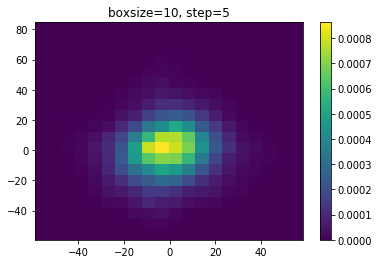

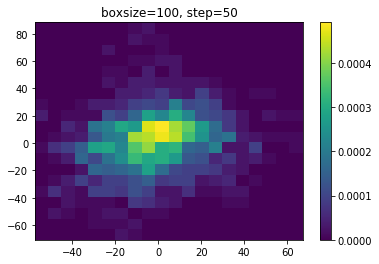

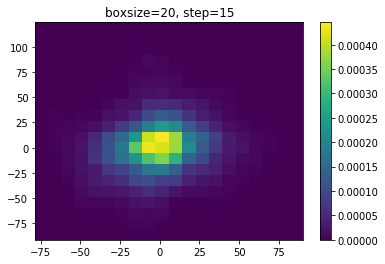

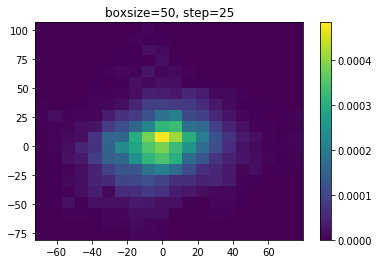

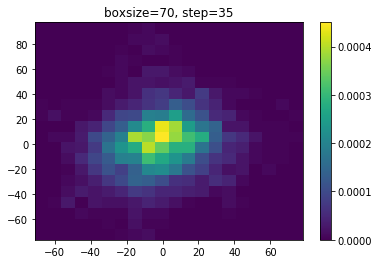

In [62]:
for boxsize in boxsizeL:    
    stepL = next(os.walk(os.path.join(folder, boxsize)))[1]
    for step in stepL:
        plt.figure()
        l = cl.readdata(os.path.join(folder, boxsize, step))
        pivData = pd.read_csv(l.Dir[10])
        plot_velocity_distributions(pivData)
        plt.title(boxsize+', '+step)

<b>Comment:</b> We have chosen 10, 20, 50, 70, 100 pixels as box size to test its effect on PIV results. When box size is equal to 10, the distribution of velocity is very different from all other cases, with a very high probability at small velocity. This indicates that the box size is too small to capture large displacements which happens in reality. Box size = 20 shows a problem similar to 10, but not as strong. Box size 50, 70 and 100 show similar velocity distributions, indicating that this is a good range for choosing PIV box size. I should quantify the similarity of the velocity distribution.

## Improvement
<ul>
    <li> Remove boundary: we notice that anomalous divergence often happens near boundaries (shown below).
        <img src="https://zloverty.github.io/research/DF/img/boundary-error.PNG" width=250px></li>
    <li> Smooth temporally: We expect the velocity at each lattice to change smoothly. However, we notice that the velocity at certain lattices changes too dramatically, which results in the dramatic change of divergence fields (mentioned above). This is not physical, and we hope to resolve this issue by smoothing the velocity fields. The smoothing will be done in two ways:
        <ul>
            <li> Temporal smoothing </li>
            <li> Spatial smoothing (Moving Least-Square Method) </li>
        </ul>
    </li>
</ul>


In [165]:
# 3. Moving least square smoothing (spatial)

# determine neighbors
def determine_neighbors(pivData, coords, dm):
    dist = ((pivData.x - coords[0])**2 + (pivData.y-coords[1])**2)**.5
    neighbors = pivData[dist<=dm]
    return neighbors

In [170]:
%%time
coords = [50, 50]
dm = 100
neighbors = determine_neighbors(pivData, coords, dm)
neighbors

Wall time: 2 ms


,x,y,u,v
0,25.0,25.0,6.433720,3.812552
1,50.0,25.0,0.919117,6.965334
2,75.0,25.0,0.537739,6.410238
3,100.0,25.0,4.679572,0.373280
4,125.0,25.0,10.503171,-3.432874
80,25.0,50.0,3.711849,-2.203560
81,50.0,50.0,-2.682172,2.156047
82,75.0,50.0,-6.023195,5.327733
83,100.0,50.0,-5.178999,6.837724
84,125.0,50.0,2.016891,0.434896


In [138]:
%%time
dist = ((pivData.x - coords[0])**2 + (pivData.y-coords[1])**2)**.5
neighbors = np.array(pivData[dist<=50].drop(labels=['u', 'v'], axis='columns'))

Wall time: 70 ms


In [56]:
# weight function
def weight_function(coords1, coords2, dm):
    # here we still introduce dm, in case the neighbor list is not correct
    distsq = (coords1[0] - coords2[0]) ** 2 + (coords1[1] - coords2[1]) ** 2
    if distsq <= dm**2:
        f = (np.exp(1-distsq/dm**2) - 1) / (np.e - 1)
    else:
        f = 0
    return f

In [57]:
f =  weight_function(coords_list[0], coords_list[2], dm)
f

0.6500679912412274

In [148]:
# calculate matrix A
def calculate_matrix_A(coords, neighbors, dm):
    # assume polynomial basis for trial
    k = 0
    for num, i in neighbors.iterrows():
        c = [i.x, i.y]
        P = cubic_basis(c)
        if k == 0:
            A = weight_function(coords, c, dm) * np.outer(P, P)
        else:
            A += weight_function(coords, c, dm) * np.outer(P, P)
        k += 1
    return A    

In [151]:
%%time
A = calculate_matrix_A(coords, neighbors, dm)
A

Wall time: 2.01 ms


array([[5.11043464e+00, 2.55521732e+02, 2.55521732e+02, 1.45325233e+04,
        1.45325233e+04, 1.27760866e+04, 9.02269829e+05, 9.02269829e+05,
        7.26626163e+05, 7.26626163e+05],
       [2.55521732e+02, 1.45325233e+04, 1.27760866e+04, 9.02269829e+05,
        7.26626163e+05, 7.26626163e+05, 5.93845393e+07, 4.51134915e+07,
        4.51134915e+07, 4.13123071e+07],
       [2.55521732e+02, 1.27760866e+04, 1.45325233e+04, 7.26626163e+05,
        9.02269829e+05, 7.26626163e+05, 4.51134915e+07, 5.93845393e+07,
        4.13123071e+07, 4.51134915e+07],
       [1.45325233e+04, 9.02269829e+05, 7.26626163e+05, 5.93845393e+07,
        4.13123071e+07, 4.51134915e+07, 4.06699988e+09, 2.56371525e+09,
        2.96922697e+09, 2.56371525e+09],
       [1.45325233e+04, 7.26626163e+05, 9.02269829e+05, 4.13123071e+07,
        5.93845393e+07, 4.51134915e+07, 2.56371525e+09, 4.06699988e+09,
        2.56371525e+09, 2.96922697e+09],
       [1.27760866e+04, 7.26626163e+05, 7.26626163e+05, 4.51134915e+07,
   

In [53]:
# inverse of matrix A
np.linalg.inv(A)

array([[ 7.38284554e-01, -5.23374967e-03, -5.23374967e-03],
       [-5.23374967e-03,  7.79931873e-05,  4.29381378e-06],
       [-5.23374967e-03,  4.29381378e-06,  7.79931873e-05]])

In [149]:
# calculate matrix B
def calculate_matrix_B(coords, neighbors, dm):
    # assume polynomial basis for trial
    B = []
    k = 0
    for num, i in neighbors.iterrows():
        c = [i.x, i.y]
        P = cubic_basis(c)
        B.append(weight_function(coords, c, dm) * P)
    return np.array(B)

In [150]:
%%time
B = calculate_matrix_B(coords, neighbors, dm)
B

Wall time: 2 ms


array([[3.77540669e-01, 9.43851672e+00, 9.43851672e+00, 2.35962918e+02,
        2.35962918e+02, 2.35962918e+02, 5.89907295e+03, 5.89907295e+03,
        5.89907295e+03, 5.89907295e+03],
       [6.50067991e-01, 3.25033996e+01, 1.62516998e+01, 1.62516998e+03,
        4.06292495e+02, 8.12584989e+02, 8.12584989e+04, 1.01573124e+04,
        4.06292495e+04, 2.03146247e+04],
       [3.77540669e-01, 2.83155502e+01, 9.43851672e+00, 2.12366626e+03,
        2.35962918e+02, 7.07888754e+02, 1.59274970e+05, 5.89907295e+03,
        5.30916565e+04, 1.76972188e+04],
       [6.50067991e-01, 1.62516998e+01, 3.25033996e+01, 4.06292495e+02,
        1.62516998e+03, 8.12584989e+02, 1.01573124e+04, 8.12584989e+04,
        2.03146247e+04, 4.06292495e+04],
       [1.00000000e+00, 5.00000000e+01, 5.00000000e+01, 2.50000000e+03,
        2.50000000e+03, 2.50000000e+03, 1.25000000e+05, 1.25000000e+05,
        1.25000000e+05, 1.25000000e+05],
       [6.50067991e-01, 4.87550993e+01, 3.25033996e+01, 3.65663245e+03,
   

In [152]:
# get exp data
def get_exp_data(pivData, neighbors):
    w = []
    for num, i in neighbors.iterrows():
        c = [i.x, i.y]
        subdata = pivData.loc[(pivData.x==c[0])&(pivData.y==c[1])]
        w.append([subdata.u.values[0], subdata.v.values[0]])
    return np.array(w).transpose()

In [105]:
# calculate cubic basis
def cubic_basis(coords):
    x = coords[0]
    y = coords[1]
    P = np.array([1, x, y, x**2, y**2, x*y, x**3, y**3, x**2*y, x*y**2])
    return P

In [153]:
%%time
w = get_exp_data(pivData, neighbors)
w

Wall time: 17 ms


array([[ 6.43372012,  0.91911662,  0.53773903,  3.711849  , -2.68217164,
        -6.02319488, -5.17899917,  1.2880826 , -3.81062425, -9.31535777,
        -0.47398203],
       [ 3.8125518 ,  6.96533421,  6.41023805, -2.20355993,  2.15604739,
         5.32773276,  6.83772377, -4.22195312, -2.40841589,  1.21482942,
        -1.45118033]])

In [91]:
c = neighbors[0]
subdata = pivData.loc[(pivData.x==c[0])&(pivData.y==c[1])]

In [188]:
np.inner(np.linalg.inv(A), B).shape

(10, 11)

In [185]:
%%time
np.inner(np.inner(cubic_basis(coords), np.inner(np.linalg.inv(A), B).transpose()), w)

Wall time: 0 ns


array([-1.89143861,  0.61792266])

In [191]:
np.inner(cubic_basis(coords), np.inner(np.inner(np.linalg.inv(A), B), w).transpose())

array([-1.89143861,  0.61792266])

In [198]:
coef = np.inner(np.inner(np.linalg.inv(A), B), w).transpose()

In [199]:
coef

array([[ 2.84092108e+01, -4.12673133e-01, -5.03345199e-01,
        -3.32193145e-04,  4.46046364e-03,  2.22675432e-03,
         5.95353449e-05, -2.15363232e-05, -8.86280411e-05,
         4.75306608e-05],
       [ 5.56371855e+00,  6.34939625e-02, -1.63774794e-01,
         1.47110508e-03, -4.29931304e-03,  3.55248644e-03,
        -5.19519534e-05,  6.21808283e-05,  8.82813862e-05,
        -1.12449865e-04]])

In [200]:
coef.flatten()

array([ 2.84092108e+01, -4.12673133e-01, -5.03345199e-01, -3.32193145e-04,
        4.46046364e-03,  2.22675432e-03,  5.95353449e-05, -2.15363232e-05,
       -8.86280411e-05,  4.75306608e-05,  5.56371855e+00,  6.34939625e-02,
       -1.63774794e-01,  1.47110508e-03, -4.29931304e-03,  3.55248644e-03,
       -5.19519534e-05,  6.21808283e-05,  8.82813862e-05, -1.12449865e-04])

In [145]:
pivData.loc[(pivData.x==coords[0])&(pivData.y==coords[1])]

,x,y,u,v
81,50.0,50.0,-2.682172,2.156047


In [207]:
dm = 100

In [204]:
# 1 frame process using MLS
def mls_smoothing_1(pivData, dm):
    uv = []
    coefL = []
    for num, i in pivData.iterrows():
        coords = [i.x, i.y]
        neighbors = determine_neighbors(pivData, coords, dm)
        A = calculate_matrix_A(coords, neighbors, dm)
        B = calculate_matrix_B(coords, neighbors, dm)
        w = get_exp_data(pivData, neighbors)
        coef1 = np.inner(np.inner(np.linalg.inv(A), B), w).transpose()
        coefL.append(coef1.flatten())
        smoothed_velocity = np.inner(np.inner(cubic_basis(coords), np.inner(np.linalg.inv(A), B).transpose()), w)
        uv.append(smoothed_velocity)
    uv = np.array(uv)
    coefL = np.array(coefL)
    smoothed_piv = pd.DataFrame().assign(x=pivData.x, y=pivData.y, u=uv[:, 0], v=uv[:, 1])
    coef = pd.DataFrame().assign(x=pivData.x, y=pivData.y, 
                                 u_1=coefL[:, 0], u_x=coefL[:, 1], u_y=coefL[:, 2], u_x2=coefL[:, 3], u_y2=coefL[:, 4],
                                 u_xy=coefL[:, 5], u_x3=coefL[:, 6], u_y3=coefL[:, 7], u_x2y=coefL[:, 8], u_y2x=coefL[:, 9],
                                 v_1=coefL[:, 10], v_x=coefL[:, 11], v_y=coefL[:, 12], v_x2=coefL[:, 13], v_y2=coefL[:, 14],
                                 v_xy=coefL[:, 15], v_x3=coefL[:, 16], v_y3=coefL[:, 17], v_x2y=coefL[:, 18], v_y2x=coefL[:, 19])
    return smoothed_piv, coef

In [208]:
%%time
smoothed, coef = mls_smoothing_1(pivData, dm)

Wall time: 8min 18s


In [205]:
%%time
smoothed1, coef = mls_smoothing_1(pivData, dm)

Wall time: 2min 13s


In [210]:
coef

,x,y,u_1,u_x,u_y,u_x2,u_y2,u_xy,u_x3,u_y3,...,v_1,v_x,v_y,v_x2,v_y2,v_xy,v_x3,v_y3,v_x2y,v_y2x
0,25.0,25.0,1.348194e+01,-0.317201,0.135070,0.001549,-0.005594,-0.001290,1.821396e-05,0.000037,...,1.121295e-01,0.378141,-0.046105,-0.004094,-0.003816,-0.001374,-0.000008,0.000045,8.622855e-05,-0.000053
1,50.0,25.0,1.348418e+01,-0.312599,0.128820,0.002337,-0.004853,-0.002972,6.893585e-06,0.000035,...,4.749978e+00,0.118351,-0.094500,-0.001301,-0.004634,0.003046,-0.000011,0.000048,4.143091e-05,-0.000050
2,75.0,25.0,1.828115e+01,-0.506387,0.028293,0.005220,-0.003573,-0.002014,-8.305658e-06,0.000034,...,6.363233e+00,0.024976,-0.084084,-0.000892,-0.005412,0.005015,-0.000003,0.000041,-6.857867e-07,-0.000017
3,100.0,25.0,2.072781e+01,-0.597431,-0.018295,0.006834,-0.002716,-0.002721,-1.932062e-05,0.000049,...,7.893383e+00,0.003337,-0.128972,-0.001736,-0.005697,0.007810,0.000008,0.000013,-4.867701e-05,0.000037
4,125.0,25.0,1.371348e+01,-0.420014,0.093060,0.005766,-0.002314,-0.005886,-2.011155e-05,0.000075,...,-6.733615e+00,0.574050,-0.279715,-0.007759,-0.004743,0.009484,0.000028,-0.000010,-6.390077e-05,0.000061
5,150.0,25.0,-8.029519e+00,0.008925,0.300204,0.003455,-0.000527,-0.010694,-1.663148e-05,0.000073,...,-8.332969e+01,2.164377,0.395127,-0.016999,0.000908,-0.006372,0.000043,-0.000029,6.789386e-07,0.000048
6,175.0,25.0,-4.350633e+01,0.993596,-0.577398,-0.004608,0.000746,0.000394,4.694628e-06,0.000030,...,-1.074931e+02,2.491041,0.603895,-0.016810,0.016817,-0.019427,0.000037,-0.000061,5.876102e-05,-0.000014
7,200.0,25.0,3.285031e+00,0.642918,-2.373957,-0.005185,-0.001486,0.021675,1.074338e-05,-0.000007,...,2.607244e+02,-3.407467,-1.154994,0.015303,0.040448,-0.013067,-0.000022,-0.000100,6.419695e-05,-0.000103
8,225.0,25.0,1.284792e+02,-0.900119,-3.689870,0.000910,-0.002254,0.034312,2.946045e-06,-0.000009,...,7.909283e+02,-10.524305,-3.811927,0.047056,0.054959,0.005353,-0.000069,-0.000124,3.179104e-05,-0.000150
9,250.0,25.0,1.959517e+02,-2.080433,-2.071043,0.007401,0.001030,0.018712,-8.598308e-06,0.000015,...,9.409553e+02,-11.924660,-5.918053,0.050228,0.043172,0.028702,-0.000069,-0.000120,-2.727273e-05,-0.000104


In [217]:
# Take derivatives of the cubic fitting
def cubic_derivatives(coef):
#     coef = np.array(coef)
    dudxL = []
    dudyL = []
    dvdxL = []
    dvdyL = []
    for num, i in coef.iterrows():
        x = i['x']
        y = i['y']
        dudx = i['u_x'] + i['u_x2']*2*x + i['u_xy']*y + i['u_x3']*3*x**2 + i['u_x2y']*2*x*y + i['u_y2x']*y**2
        dudy = i['u_y'] + i['u_y2']*2*y + i['u_xy']*x + i['u_y3']*3*y**2 + i['u_y2x']*2*x*y + i['u_x2y']*x**2
        dvdx = i['v_x'] + i['v_x2']*2*x + i['v_xy']*y + i['v_x3']*3*x**2 + i['v_x2y']*2*x*y + i['v_y2x']*y**2
        dvdy = i['v_y'] + i['v_y2']*2*y + i['v_xy']*x + i['v_y3']*3*y**2 + i['v_y2x']*2*x*y + i['v_x2y']*x**2
        dudxL.append(dudx)
        dudyL.append(dudy)
        dvdxL.append(dvdx)
        dvdyL.append(dvdy)
    deriv = pd.DataFrame().assign(x=coef['x'], y=coef['y'], dudx=dudxL, dudy=dudyL, dvdx=dvdxL, dvdy=dvdyL)
    return deriv

In [218]:
deriv = cubic_derivatives(coef)

In [161]:
pivData

,x,y,u,v
0,25.0,25.0,6.433720,3.812552
1,50.0,25.0,0.919117,6.965334
2,75.0,25.0,0.537739,6.410238
3,100.0,25.0,4.679572,0.373280
4,125.0,25.0,10.503171,-3.432874
5,150.0,25.0,17.931077,-4.817019
6,175.0,25.0,15.720301,-4.519211
7,200.0,25.0,13.751323,-1.907862
8,225.0,25.0,9.500993,7.622104
9,250.0,25.0,17.859133,30.080908


In [174]:
smoothed

,x,y,u,v
0,25.0,25.0,6.385626,3.702187
1,50.0,25.0,1.456205,6.325098
2,75.0,25.0,0.601961,5.420066
3,100.0,25.0,4.631301,1.873688
4,125.0,25.0,10.516887,-2.715799
5,150.0,25.0,15.760115,-5.637501
6,175.0,25.0,16.214991,-6.249711
7,200.0,25.0,14.150601,-0.777162
8,225.0,25.0,12.787328,11.012952
9,250.0,25.0,14.145825,25.585810


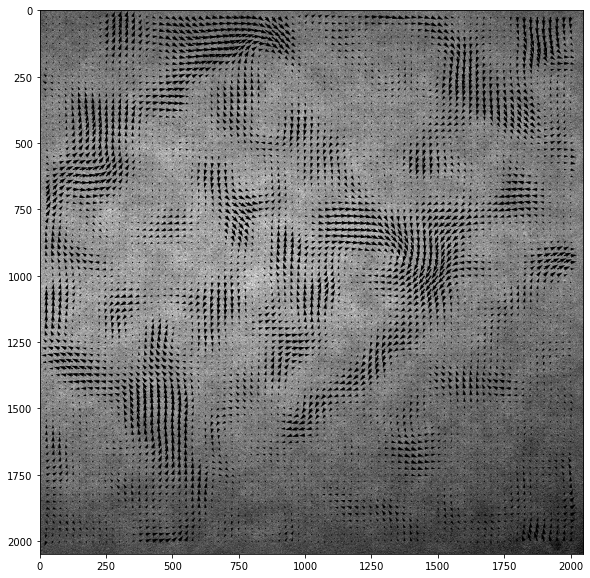

In [226]:
plt.figure(figsize=(10,10))
plt.imshow(io.imread(r'E:\moreData\02042020\80-1\8-bit\0000.tif'), cmap='gray')
plt.quiver(smoothed.x, smoothed.y, smoothed.u, smoothed.v)

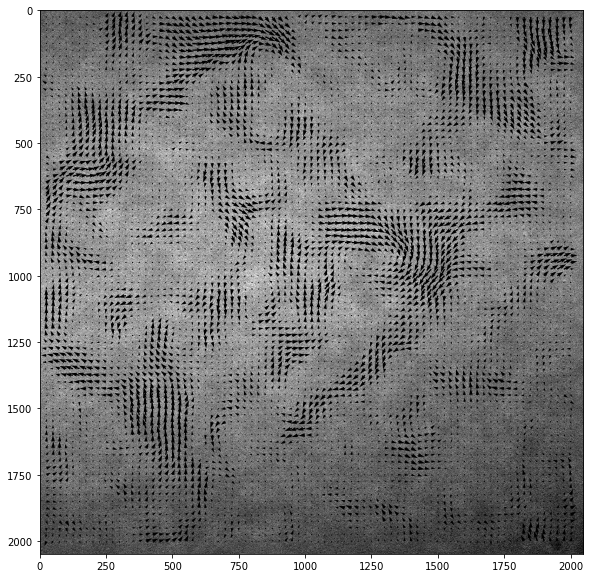

In [227]:
plt.figure(figsize=(10,10))
plt.imshow(io.imread(r'E:\moreData\02042020\80-1\8-bit\0000.tif'), cmap='gray')
plt.quiver(pivData.x, pivData.y, pivData.u, pivData.v)

## Compare divergence field

In [180]:
img = io.imread(r'E:\moreData\02042020\80-1\8-bit\0000.tif')
c, v, divcn, divcv, divv = cl.div_field(img, pivData, 50, 25)

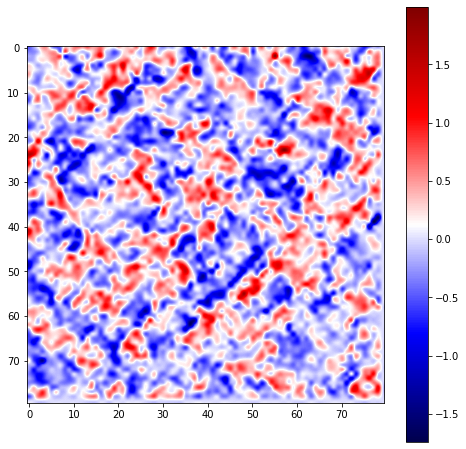

In [230]:
plt.figure(figsize=(8,8))
plt.imshow(divv/25, interpolation='spline16', cmap='seismic')
plt.colorbar()

In [222]:
divv2 = np.array(deriv.dudx+deriv.dvdy).reshape(80, 80)

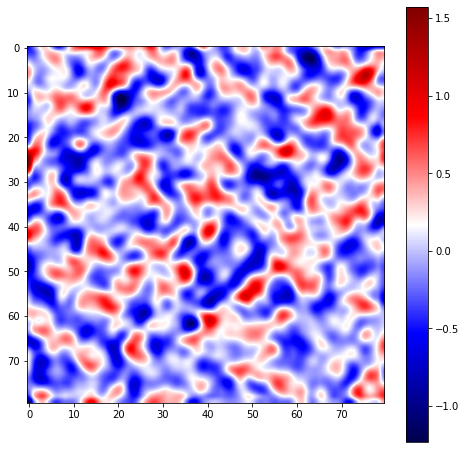

In [229]:
plt.figure(figsize=(8,8))
plt.imshow(divv2, interpolation='spline16', cmap='seismic')
plt.colorbar()

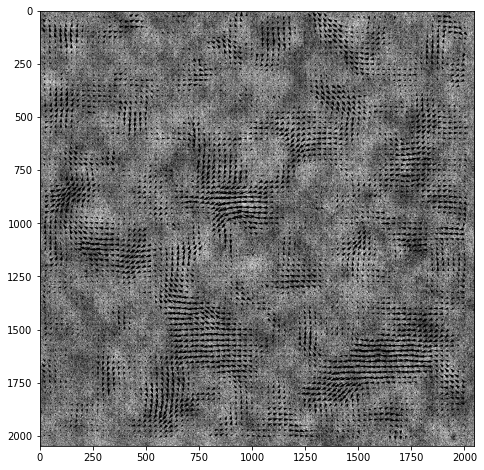

In [260]:
pivData = pd.read_csv(r'E:\Google Drive\data_share\Dynamics_raw\concentration_velocity_field\piv_result_50\80\992-993.csv')
img = io.imread(r'E:\Google Drive\data_share\Dynamics_raw\processed_image\80_bp\998.tif')
c, v, divcn, divcv, divv = cl.div_field(img, pivData, 50, 25)
plt.figure(figsize=(8,8))
plt.imshow(img, cmap='gray')
plt.quiver(pivData.x, pivData.y, pivData.u, pivData.v)

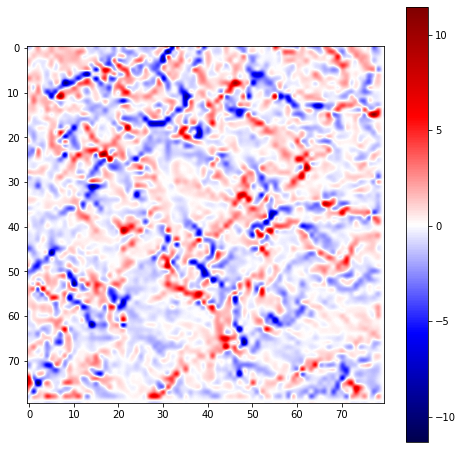

In [262]:
plt.figure(figsize=(8,8))
plt.imshow(divcn/25, interpolation='spline16', cmap='seismic')
plt.colorbar()

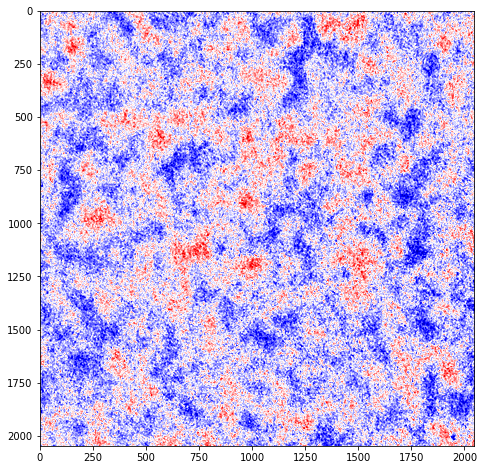

In [253]:
plt.figure(figsize=(8,8))
plt.imshow(img, interpolation='spline16', cmap='seismic')

In [19]:
# 4. Temporal smoothing
# Idea: regard time as the third dimension in addition to spatial dimensions x and y. 
# Define d_t as the cutoff distance within which the velocity is smoothed.


92.58012423674565

In [17]:
# TEST
a = np.array([[1, 2], [3, 4]])
b = np.array([[5, 6], [7, 8]])

In [21]:
c = np.array([a, b])

In [22]:
c[0][0][1]

2

In [24]:
c[1, 0, 0]

5

In [30]:
d = np.stack([a, b], axis=2)

In [37]:
d[1, 0, 0]

3